# Arima Models for California Counties 

In [31]:
import warnings
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import r2_score, mean_squared_error
warnings.filterwarnings('ignore')
from statsmodels.tsa.arima.model import ARIMA

In [32]:
data = pd.read_csv('finalized_county.csv')

In [33]:
california_data = data[data['state'] == 'California']
california_data['date'] = pd.to_datetime(california_data['date'], format="%Y-%m-%d")
california_data['county'].unique()

array(['Los Angeles', 'Orange', 'San Diego'], dtype=object)

## Los Angeles

In [34]:
la = california_data[california_data['county'] == 'Los Angeles'].loc[:, ['date', 'incremental_cases']]

def stationary_test(series):
    result = adfuller(series)
    return (result[0], result[1])

# LA data is non-stationary without any differencing
stationary_test(la.incremental_cases)

# test statistic (hypothesis that non-stationarity cannot be rejected)
# p-value is greater than 0.05 

(1.3190762222252403, 0.9967136380720155)

In [6]:
# first-level differencing
la['incremental_cases'] = la['incremental_cases'].diff().fillna(la['incremental_cases']).astype('int')

# la is still non-stationary after first-level differencing
stationary_test(la.incremental_cases)

# test statistic (hypothesis that non-stationarity cannot be rejected)
# p-value is greater than 0.05 

(-0.934092662079519, 0.7765380334868845)

In [7]:
# second-level differencing
la['incremental_cases'] = la['incremental_cases'].diff().fillna(la['incremental_cases']).astype('int')

# la is stationary after second-level differencing
stationary_test(la.incremental_cases)

# test statistic (hypothesis that non-stationarity can be rejected)
# p-value is much less than 0.05

(-8.591013100393987, 7.286147751265899e-14)

In [8]:
# using differenced cases for train
train = la.iloc[:230, :]

<Axes: xlabel='date', ylabel='incremental_cases'>

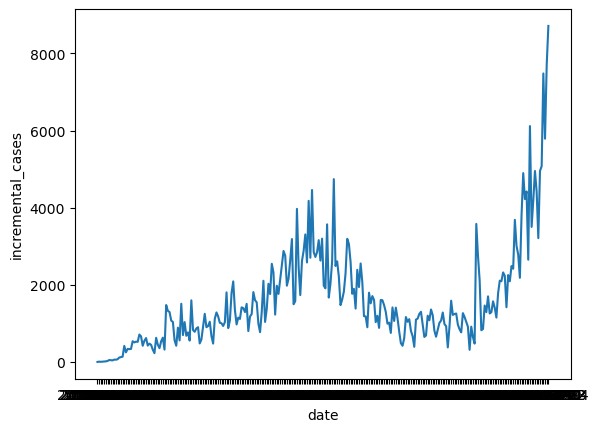

In [9]:
# use non-differenced cases for test actuals
testing = data[data['county'] == 'Los Angeles'].loc[:, ['date', 'incremental_cases']]
test = testing.iloc[230:, :]

sns.lineplot(x="date", y="incremental_cases",legend = 'full' , data=testing)

### Baseline Model

In [10]:
model = ARIMA(train.incremental_cases, order=(0, 0, 0)).fit()
pred = pd.concat([pd.Series([-62]), model.forecast(steps=40)]).cumsum()[1:]
pred = pd.concat([pd.Series([101]), pred]).cumsum()[1:]
r2 = r2_score(test.incremental_cases, pred)
print("R-squared", r2) 

R-squared -13.079396904207744


<Axes: xlabel='date'>

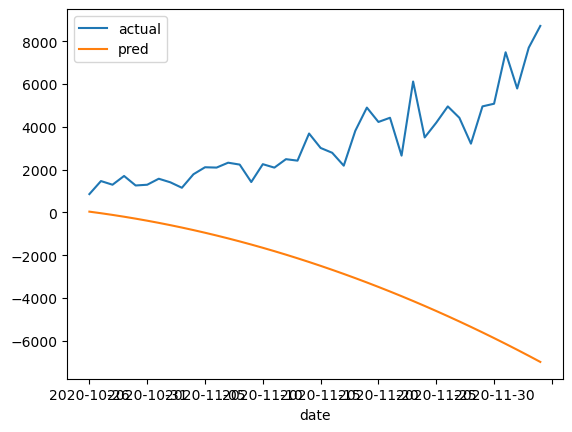

In [11]:
prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True), 
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

### Tuning Hyperparameters

In [12]:
p_values = [0, 1, 5, 8]
d_values = [0, 1, 2, 5]
q_values = [0, 1, 2, 5, 10]
vals = []
prev = 100000000000000000000000000
for p in p_values:
    for d in d_values:
        for q in q_values:
            param = (p, d, q)
            model = ARIMA(train.incremental_cases, order=param).fit()
            pred = model.forecast(steps=40)
            pred = pd.concat([pd.Series([-62]), pred]).cumsum()[1:]
            pred = pd.concat([pd.Series([101]), pred]).cumsum()[1:]
            mse = mean_squared_error(test.incremental_cases, pred)
            if mse < prev:
                prev = mse
                best = param
            print(mse, 'for parameters', param)
print(best, prev)

52161172.875081085 for parameters (0, 0, 0)
617860860.608931 for parameters (0, 0, 1)
666163016.3960731 for parameters (0, 0, 2)
731969206.2406031 for parameters (0, 0, 5)
731997831.4528697 for parameters (0, 0, 10)
64180678493.925 for parameters (0, 1, 0)
52191610.29093392 for parameters (0, 1, 1)
617593862.6179484 for parameters (0, 1, 2)
727637867.2248311 for parameters (0, 1, 5)
784243322.9000933 for parameters (0, 1, 10)
16638568931712.309 for parameters (0, 2, 0)
70837503618.88403 for parameters (0, 2, 1)
202224694.56399798 for parameters (0, 2, 2)
826187737.945279 for parameters (0, 2, 5)
1835357851.4400756 for parameters (0, 2, 10)
1.0200286025515834e+22 for parameters (0, 5, 0)
3.848718479797599e+19 for parameters (0, 5, 1)
6.447647382275294e+16 for parameters (0, 5, 2)
1697397329279285.5 for parameters (0, 5, 5)
72160597785430.95 for parameters (0, 5, 10)
3046414.3309725253 for parameters (1, 0, 0)
640228211.8340232 for parameters (1, 0, 1)
725080210.8640406 for parameters (1

In [13]:
model = ARIMA(train.incremental_cases, order=(1, 1, 1)).fit()
pred = pd.concat([pd.Series([-62]), model.forecast(steps=40)]).cumsum()[1:]
pred = pd.concat([pd.Series([101]), pred]).cumsum()[1:]
r2 = r2_score(test.incremental_cases, pred)
r2

0.4556608901940089

<Axes: xlabel='date'>

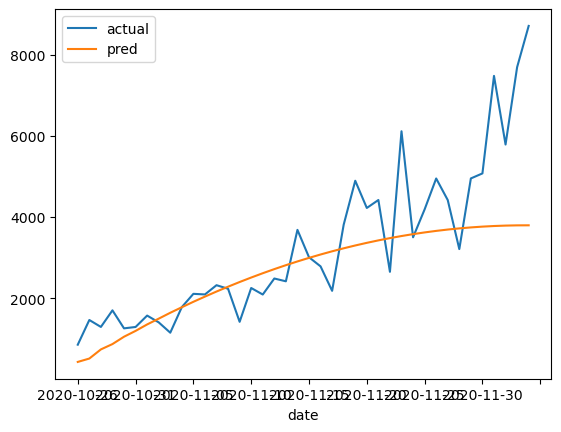

In [14]:
prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True), 
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

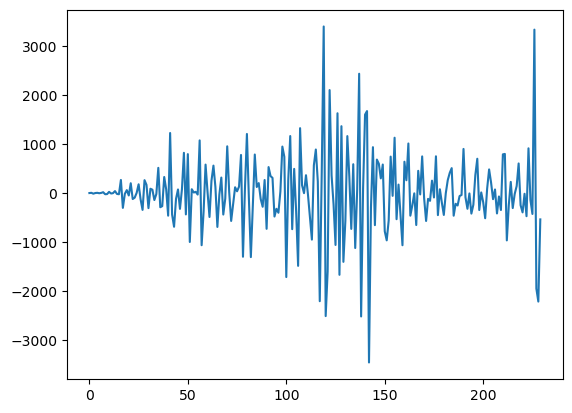

In [15]:
plt.plot(model.resid)

In [16]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      incremental_cases   No. Observations:                  230
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1858.045
Date:                Mon, 19 Feb 2024   AIC                           3722.090
Time:                        19:06:52   BIC                           3732.392
Sample:                             0   HQIC                          3726.246
                                - 230                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6091      0.032    -18.921      0.000      -0.672      -0.546
ma.L1         -1.0000      0.052    -19.082      0.000      -1.103      -0.897
sigma2      6.376e+05   8.22e-08   7.76e+12      0.000    6.38e+05    6.38e+05
===================================================================================
Ljung-Box (L1) (Q):                  14.30   Jarque-Bera (JB):               184.08
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.08   Skew:                             0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.16e+27. Standard errors may be unstable.
"""

## Orange

In [63]:
orange = california_data[california_data['county'] == 'Orange'].loc[:, ['date', 'incremental_cases']]

def stationary_test(series):
    result = adfuller(series)
    return (result[0], result[1])

# Orange data is non-stationary without any differencing
stationary_test(orange.incremental_cases)

# test statistic (hypothesis that non-stationarity cannot be rejected)
# p-value is greater than 0.05 

(-0.1897980045327783, 0.9397267929055788)

In [64]:
# first-level differencing
orange['incremental_cases'] = orange['incremental_cases'].diff().fillna(orange['incremental_cases']).astype('int')

# la is still non-stationary after first-level differencing
stationary_test(orange.incremental_cases)

# test statistic (hypothesis that non-stationarity can be rejected)
# p-value is much less than 0.05

(-10.476734705085976, 1.243438566263163e-18)

In [65]:
# using differenced cases for train
train = orange.iloc[:230, :]

<Axes: xlabel='date', ylabel='incremental_cases'>

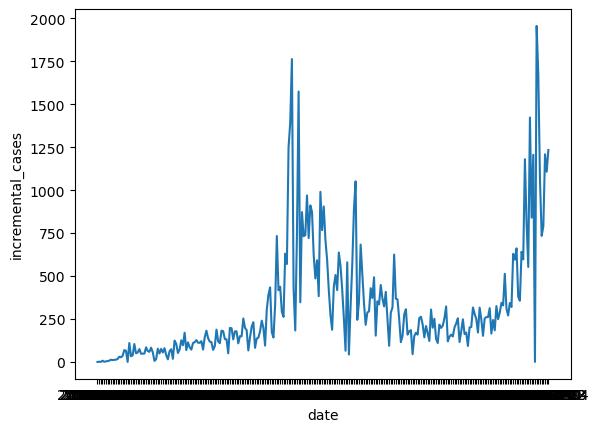

In [66]:
# use non-differenced cases for test actuals
testing = data[data['county'] == 'Orange'].loc[:, ['date', 'incremental_cases']]
test = testing.iloc[230:, :]

sns.lineplot(x="date", y="incremental_cases",legend = 'full' , data=testing)

### Baseline Model

In [67]:
model = ARIMA(train.incremental_cases, order=(0, 0, 0)).fit()
pred = pd.concat([pd.Series([-62]), model.forecast(steps=40)]).cumsum()[1:]
pred = pd.concat([pd.Series([101]), pred]).cumsum()[1:]
r2 = r2_score(test.incremental_cases, pred)
print("R-squared", r2) 

R-squared -13.303538939079122


<Axes: xlabel='date'>

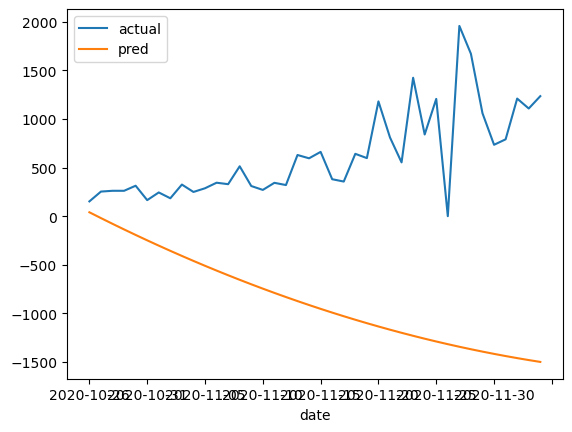

In [68]:
prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True), 
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

### Tuning Hyperparameters

In [18]:
p_values = [ 0, 1, 5]
d_values = [0, 1, 2, 5]
q_values = [0, 1, 5]
vals = []
prev = 100000000000000000000000000
for p in p_values:
    for d in d_values:
        for q in q_values:
            param = (p, d, q)
            model = ARIMA(train.incremental_cases, order=param).fit()
            pred = model.forecast(steps=40)
            pred = pd.concat([pd.Series([-62]), pred]).cumsum()[1:]
            pred = pd.concat([pd.Series([101]), pred]).cumsum()[1:]
            mse = mean_squared_error(test.incremental_cases, pred)
            if mse < prev:
                prev = mse
                best = param
            print(mse, 'for parameters', param)
print(best, prev)

2904669.5359508474 for parameters (0, 0, 0)
2783908.4332723124 for parameters (0, 0, 1)
1922591.8077651262 for parameters (0, 0, 5)
799595690.6000003 for parameters (0, 1, 0)
2950278.5484130876 for parameters (0, 1, 1)
2868793.3814353338 for parameters (0, 1, 5)
1016005812027.9 for parameters (0, 2, 0)
879993859.1073906 for parameters (0, 2, 1)
16682187.149829444 for parameters (0, 2, 5)
8.14194409903769e+18 for parameters (0, 5, 0)
7.872453575925008e+16 for parameters (0, 5, 1)
13019375871.869425 for parameters (0, 5, 5)
1728544.8368141935 for parameters (1, 0, 0)
3643728.313554482 for parameters (1, 0, 1)
1954144.5331093937 for parameters (1, 0, 5)
3522464.616037996 for parameters (1, 1, 0)
1725857.8613172516 for parameters (1, 1, 1)
3508092.888992264 for parameters (1, 1, 5)
21813082251.707863 for parameters (1, 2, 0)
3975077.749293019 for parameters (1, 2, 1)
15252023.824651424 for parameters (1, 2, 5)
8.141166807295304e+17 for parameters (1, 5, 0)
9543042074811570.0 for parameters

In [19]:
model = ARIMA(train.incremental_cases, order=(1, 0, 0)).fit()
pred = pd.concat([pd.Series([-62]), model.forecast(steps=40)]).cumsum()[1:]
pred = pd.concat([pd.Series([101]), pred]).cumsum()[1:]
r2 = r2_score(test.incremental_cases, pred)
r2

-7.5119178189826155

In [20]:
p_values = [4, 5, 6]
d_values = [0, 1, 2, 4]
q_values = [4, 5, 6]
vals = []
prev = 100000000000000000000000000
for p in p_values:
    for d in d_values:
        for q in q_values:
            param = (p, d, q)
            model = ARIMA(train.incremental_cases, order=param).fit()
            pred = model.forecast(steps=40)
            pred = pd.concat([pd.Series([-62]), pred]).cumsum()[1:]
            pred = pd.concat([pd.Series([101]), pred]).cumsum()[1:]
            mse = mean_squared_error(test.incremental_cases, pred)
            if mse < prev:
                prev = mse
                best = param
            print(mse, 'for parameters', param)
print(best, prev)

2104593.1201761225 for parameters (4, 0, 4)
1850592.9802832336 for parameters (4, 0, 5)
2018654.5756817393 for parameters (4, 0, 6)
4430784.396067204 for parameters (4, 1, 4)
3035358.9853817634 for parameters (4, 1, 5)
3566791.7794951303 for parameters (4, 1, 6)
9662738.927727718 for parameters (4, 2, 4)
62376664.74943276 for parameters (4, 2, 5)
26268056.527259342 for parameters (4, 2, 6)
15552613.318539673 for parameters (4, 4, 4)
2091578.180695448 for parameters (4, 4, 5)
4517933925.13418 for parameters (4, 4, 6)
1922121.1267764072 for parameters (5, 0, 4)
1838836.4740650975 for parameters (5, 0, 5)
2028681.848320386 for parameters (5, 0, 6)
3297671.6274935743 for parameters (5, 1, 4)
4914217.134307799 for parameters (5, 1, 5)
3438087.6163809733 for parameters (5, 1, 6)
16175311.215256948 for parameters (5, 2, 4)
519304.2540227834 for parameters (5, 2, 5)
841584.2898977831 for parameters (5, 2, 6)
2495084273.0832376 for parameters (5, 4, 4)
13044480.06555124 for parameters (5, 4, 5)

In [21]:
model = ARIMA(train.incremental_cases, order=(6, 2, 6)).fit()
pred = pd.concat([pd.Series([-62]), model.forecast(steps=40)]).cumsum()[1:]
pred = pd.concat([pd.Series([101]), pred]).cumsum()[1:]
r2 = r2_score(test.incremental_cases, pred)
r2

-0.5448740044459406

<Axes: xlabel='date'>

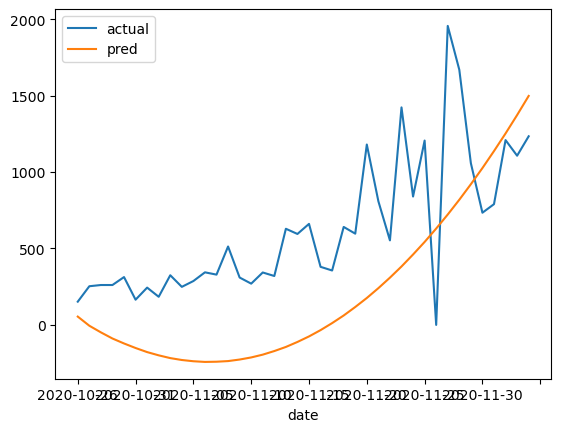

In [22]:
prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True), 
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

In [23]:
p_values = [5, 6, 7, 8]
d_values = [2, 3, 4]
q_values = [5, 6, 7, 8]
vals = []
prev = 100000000000000000000000000
for p in p_values:
    for d in d_values:
        for q in q_values:
            param = (p, d, q)
            model = ARIMA(train.incremental_cases, order=param).fit()
            pred = model.forecast(steps=40)
            pred = pd.concat([pd.Series([-62]), pred]).cumsum()[1:]
            pred = pd.concat([pd.Series([101]), pred]).cumsum()[1:]
            mse = mean_squared_error(test.incremental_cases, pred)
            if mse < prev:
                prev = mse
                best = param
            print(mse, 'for parameters', param)
print(best, prev)

519304.2540227834 for parameters (5, 2, 5)
841584.2898977831 for parameters (5, 2, 6)
447169.2134347018 for parameters (5, 2, 7)
1463471.2402159073 for parameters (5, 2, 8)
2628719.235331308 for parameters (5, 3, 5)
28769176.771878965 for parameters (5, 3, 6)
24193036.17820149 for parameters (5, 3, 7)
141840366.1355254 for parameters (5, 3, 8)
13044480.06555124 for parameters (5, 4, 5)
603085023.4418565 for parameters (5, 4, 6)
321980691.2360862 for parameters (5, 4, 7)
335664724.37898546 for parameters (5, 4, 8)
20657520.440795086 for parameters (6, 2, 5)
313722.95183092763 for parameters (6, 2, 6)
406179.95793307095 for parameters (6, 2, 7)
797911.1327411456 for parameters (6, 2, 8)
6475291.846582486 for parameters (6, 3, 5)
92795830.28842883 for parameters (6, 3, 6)
2018157.3316111143 for parameters (6, 3, 7)
191991.20609075043 for parameters (6, 3, 8)
211941372.3118211 for parameters (6, 4, 5)
580139314.0681063 for parameters (6, 4, 6)
91039966.51210564 for parameters (6, 4, 7)
445

In [24]:
model = ARIMA(train.incremental_cases, order=(6, 3, 8)).fit()
pred = pd.concat([pd.Series([-62]), model.forecast(steps=40)]).cumsum()[1:]
pred = pd.concat([pd.Series([101]), pred]).cumsum()[1:]
r2 = r2_score(test.incremental_cases, pred)
r2

0.05457276351374807

<Axes: xlabel='date'>

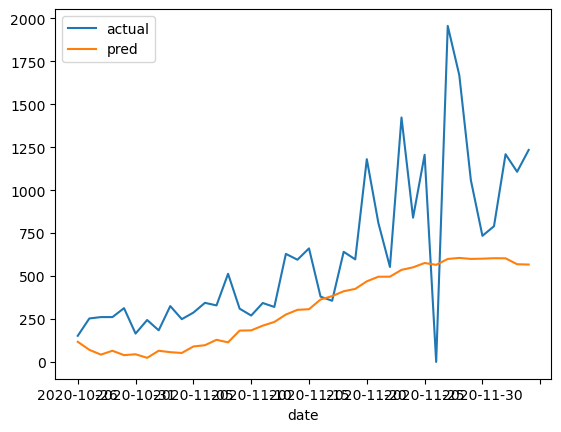

In [25]:
prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True), 
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

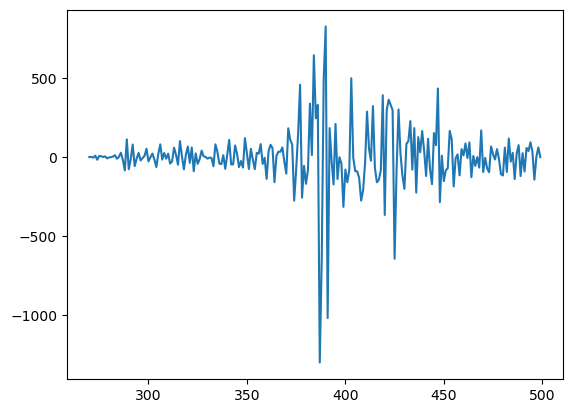

In [26]:
plt.plot(model.resid)

In [27]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:      incremental_cases   No. Observations:                  230
Model:                 ARIMA(6, 3, 8)   Log Likelihood               -1545.591
Date:                Thu, 15 Feb 2024   AIC                           3121.181
Time:                        15:46:56   BIC                           3172.556
Sample:                             0   HQIC                          3141.912
                                - 230                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -3.3955      0.113    -30.090      0.000      -3.617      -3.174
ar.L2         -5.5047      0.320    -17.196      0.000      -6.132      -4.877
ar.L3         -5.9069      0.437    -13.521      0.0

**NOTE**: Second model gives a better r_squared but looks like it has really bad predictions based on the graph. The third model has better predictions. 

Will continue to tune this one. 

## San Diego

In [69]:
sandiego = california_data[california_data['county'] == 'San Diego'].loc[:, ['date', 'incremental_cases']]

def stationary_test(series):
    result = adfuller(series)
    return (result[0], result[1])

# Orange data is non-stationary without any differencing
stationary_test(sandiego.incremental_cases)

# test statistic (hypothesis that non-stationarity cannot be rejected)
# p-value is greater than 0.05 

(0.6357611259888307, 0.9884647007943559)

In [70]:
# first-level differencing
sandiego['incremental_cases'] = sandiego['incremental_cases'].diff().fillna(sandiego['incremental_cases']).astype('int')

# la is still non-stationary after first-level differencing
stationary_test(sandiego.incremental_cases)

# test statistic (hypothesis that non-stationarity cannot be rejected)
# p-value is greater than 0.05 

(-1.5064452750852018, 0.5303205781258837)

In [71]:
# second-level differencing
sandiego['incremental_cases'] = sandiego['incremental_cases'].diff().fillna(sandiego['incremental_cases']).astype('int')

# la is stationary after second-level differencing
stationary_test(orange.incremental_cases)

# test statistic (hypothesis that non-stationarity can be rejected)
# p-value is much less than 0.05

(-10.476734705085976, 1.243438566263163e-18)

In [72]:
# using differenced cases for train
train = sandiego.iloc[:230, :]

<Axes: xlabel='date', ylabel='incremental_cases'>

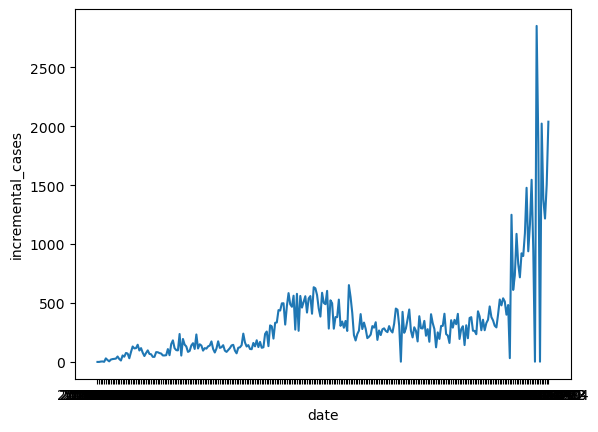

In [73]:
# use non-differenced cases for test actuals
testing = data[data['county'] == 'San Diego'].loc[:, ['date', 'incremental_cases']]
test = testing.iloc[230:, :]

sns.lineplot(x="date", y="incremental_cases",legend = 'full' , data=testing)

### Baseline Model

In [74]:
model = ARIMA(train.incremental_cases, order=(0, 0, 0)).fit()
pred = pd.concat([pd.Series([-62]), model.forecast(steps=40)]).cumsum()[1:]
pred = pd.concat([pd.Series([101]), pred]).cumsum()[1:]
r2 = r2_score(test.incremental_cases, pred)
print("R-squared", r2) 

R-squared -15.724846835540752


<Axes: xlabel='date'>

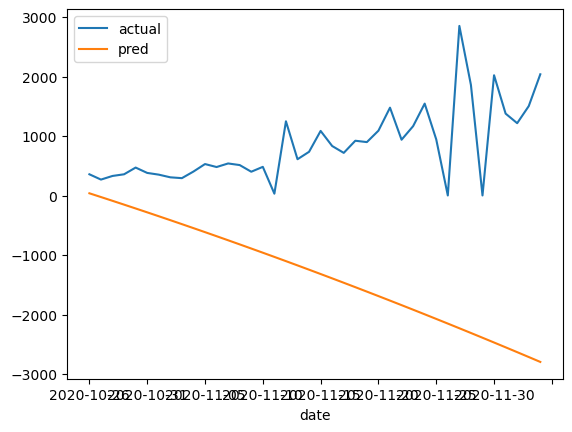

In [75]:
prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True), 
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

### Tuning Hyperparameters

In [33]:
p_values = [1, 5, 8]
d_values = [1, 5, 8]
q_values = [1, 5, 10]
vals = []
prev = 100000000000000000000000000
for p in p_values:
    for d in d_values:
        for q in q_values:
            param = (p, d, q)
            model = ARIMA(train.incremental_cases, order=param).fit()
            pred = model.forecast(steps=40)
            pred = pd.concat([pd.Series([-62]), pred]).cumsum()[1:]
            pred = pd.concat([pd.Series([101]), pred]).cumsum()[1:]
            mse = mean_squared_error(test.incremental_cases, pred)
            if mse < prev:
                prev = mse
                best = param
            print(mse, 'for parameters', param)
print(best, prev)

3246037.3650726024 for parameters (1, 1, 1)
534858.7003346432 for parameters (1, 1, 5)
464419.3255563006 for parameters (1, 1, 10)
6017597365716197.0 for parameters (1, 5, 1)
5151989448.499466 for parameters (1, 5, 5)
685299701.5054859 for parameters (1, 5, 10)
2.9969571524973016e+22 for parameters (1, 8, 1)
2037578946594073.5 for parameters (1, 8, 5)
1.179095174775304e+22 for parameters (1, 8, 10)
437791.2089974845 for parameters (5, 1, 1)
660431.1597688368 for parameters (5, 1, 5)
534117.7737326123 for parameters (5, 1, 10)
318347523872487.94 for parameters (5, 5, 1)
1077698056690.7025 for parameters (5, 5, 5)
63612624.59589596 for parameters (5, 5, 10)
1.282272351243924e+20 for parameters (5, 8, 1)
4.845447803488334e+18 for parameters (5, 8, 5)
3.896075022154711e+16 for parameters (5, 8, 10)
574364.4334101771 for parameters (8, 1, 1)
588209.0577287807 for parameters (8, 1, 5)
478333.7779943969 for parameters (8, 1, 10)
25257920113353.383 for parameters (8, 5, 1)
42765464860.1483 for

In [34]:
model = ARIMA(train.incremental_cases, order=(5, 1, 1)).fit()
pred = pd.concat([pd.Series([-62]), model.forecast(steps=40)]).cumsum()[1:]
pred = pd.concat([pd.Series([101]), pred]).cumsum()[1:]
r2 = r2_score(test.incremental_cases, pred)
r2

-0.13578540913728365

In [35]:
p_values = [4, 5, 3]
d_values = [0, 1, 2]
q_values = [0, 1, 2]
vals = []
prev = 100000000000000000000000000
for p in p_values:
    for d in d_values:
        for q in q_values:
            param = (p, d, q)
            model = ARIMA(train.incremental_cases, order=param).fit()
            pred = model.forecast(steps=40)
            pred = pd.concat([pd.Series([-62]), pred]).cumsum()[1:]
            pred = pd.concat([pd.Series([101]), pred]).cumsum()[1:]
            mse = mean_squared_error(test.incremental_cases, pred)
            if mse < prev:
                prev = mse
                best = param
            print(mse, 'for parameters', param)
print(best, prev)

497206.69823325175 for parameters (4, 0, 0)
428575.17749834666 for parameters (4, 0, 1)
419702.699808748 for parameters (4, 0, 2)
44716199.813621104 for parameters (4, 1, 0)
492017.2237459665 for parameters (4, 1, 1)
327644.1489308453 for parameters (4, 1, 2)
58408514197.21956 for parameters (4, 2, 0)
51560662.24979344 for parameters (4, 2, 1)
475408.2344499151 for parameters (4, 2, 2)
440108.02659520507 for parameters (5, 0, 0)
421030.18156247295 for parameters (5, 0, 1)
428331.81407978 for parameters (5, 0, 2)
6290993.548164277 for parameters (5, 1, 0)
437791.2089974845 for parameters (5, 1, 1)
504450.85460717586 for parameters (5, 1, 2)
9163314281.179 for parameters (5, 2, 0)
7771916.273366404 for parameters (5, 2, 1)
417386.2980889222 for parameters (5, 2, 2)
310483.6822983379 for parameters (3, 0, 0)
437400.6242588939 for parameters (3, 0, 1)
439471.0666379884 for parameters (3, 0, 2)
327514603.9868371 for parameters (3, 1, 0)
308003.1797535491 for parameters (3, 1, 1)
583206.9784

In [36]:
model = ARIMA(train.incremental_cases, order=(3, 2, 2)).fit()
pred = pd.concat([pd.Series([-62]), model.forecast(steps=40)]).cumsum()[1:]
pred = pd.concat([pd.Series([101]), pred]).cumsum()[1:]
r2 = r2_score(test.incremental_cases, pred)
r2

0.28840518673591775

In [37]:
p_values = [1, 3, 6]
d_values = [0, 2, 4]
q_values = [0, 2, 4]
vals = []
prev = 100000000000000000000000000
for p in p_values:
    for d in d_values:
        for q in q_values:
            param = (p, d, q)
            model = ARIMA(train.incremental_cases, order=param).fit()
            pred = model.forecast(steps=40)
            pred = pd.concat([pd.Series([-62]), pred]).cumsum()[1:]
            pred = pd.concat([pd.Series([101]), pred]).cumsum()[1:]
            mse = mean_squared_error(test.incremental_cases, pred)
            if mse < prev:
                prev = mse
                best = param
            print(mse, 'for parameters', param)
print(best, prev)

3182874.460221919 for parameters (1, 0, 0)
422667.5999630402 for parameters (1, 0, 2)
419077.74471971684 for parameters (1, 0, 4)
386584582962.46716 for parameters (1, 2, 0)
18559307.02750612 for parameters (1, 2, 2)
494560888234831.8 for parameters (1, 2, 4)
5659969537453347.0 for parameters (1, 4, 0)
513282586130.92444 for parameters (1, 4, 2)
359315604.5594057 for parameters (1, 4, 4)
310483.6822983379 for parameters (3, 0, 0)
439471.0666379884 for parameters (3, 0, 2)
503327.8693077719 for parameters (3, 0, 4)
166388965885.7691 for parameters (3, 2, 0)
274285.92682120536 for parameters (3, 2, 2)
1742367.709193147 for parameters (3, 2, 4)
2208955392009.3223 for parameters (3, 4, 0)
229057047838.3772 for parameters (3, 4, 2)
2405241699.3999615 for parameters (3, 4, 4)
358489.5627210565 for parameters (6, 0, 0)
422192.7822110794 for parameters (6, 0, 2)
524763.6500831761 for parameters (6, 0, 4)
5297963140.536139 for parameters (6, 2, 0)
7767263.592152851 for parameters (6, 2, 2)
8846

In [38]:
model = ARIMA(train.incremental_cases, order=(3, 2, 2)).fit()
pred = pd.concat([pd.Series([-62]), model.forecast(steps=40)]).cumsum()[1:]
pred = pd.concat([pd.Series([101]), pred]).cumsum()[1:]
r2 = r2_score(test.incremental_cases, pred)
r2

0.28840518673591775

<Axes: xlabel='date'>

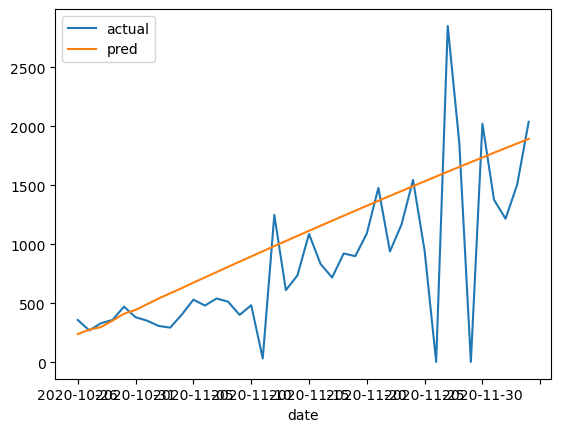

In [39]:
prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True), 
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

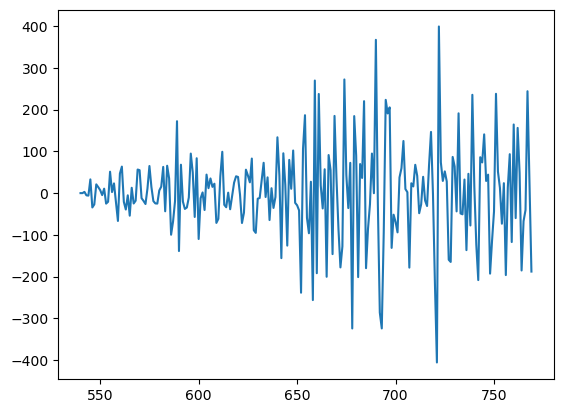

In [40]:
plt.plot(model.resid)

In [41]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:      incremental_cases   No. Observations:                  230
Model:                 ARIMA(3, 2, 2)   Log Likelihood               -1407.650
Date:                Thu, 15 Feb 2024   AIC                           2827.300
Time:                        15:47:20   BIC                           2847.876
Sample:                             0   HQIC                          2835.602
                                - 230                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1607      0.055    -21.013      0.000      -1.269      -1.052
ar.L2         -0.7771      0.086     -9.062      0.000      -0.945      -0.609
ar.L3         -0.3166      0.069     -4.574      0.0

# Seasonal Arima

# Auto Arima Models for California Counties 

# Prophet univariate